In [1]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from KE.classifier.prepare import split_dataset
from KE.dataclean import tables

In [3]:
import random
import numpy as np
import os

In [4]:
RANDOM_SEED = 12
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

random_seed = random.seed
print(random.seed)
print(np.random.get_state())

<bound method Random.seed of <random.Random object at 0x10183e010>>
('MT19937', array([        12,  274362557, 2871959443,   96505144, 3440553756,
       3320819264, 1671863157, 2853726411, 3576948821, 2267721719,
       1471449267,  205467717,  329644101, 2017124422,  120683281,
       3671631556, 3425389459, 2306138081, 2854342561, 2833917538,
       2139784180, 1777806526, 3803176561, 3129722129, 3441486743,
       1830495613, 3911788038,  683126036, 2275605760, 2143413223,
       1841233884, 3193124688, 3131946362,  854446201,  464715999,
       3543117598, 3696335765,  563062867, 3171341285, 2053716298,
       3493445055, 2373285717, 2744558717, 1005575494, 2549531338,
       3054493973,  794434881,  553407444, 3342173908, 2703770116,
       1986085520, 3203783784, 2832904198,  647337417,  715893123,
       2584083430,  191194412,  374961813, 3419702787, 3499023931,
       1892787284,  234508998, 1165532764, 2246131696,  884260026,
        627310499,   95884945,  105283704, 147383

In [5]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_11816/2785372968.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")


In [54]:
data_nodes = pd.read_csv("../data/merged/merged-kg_nodes.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_11816/1774402256.py:1: DtypeWarning: Columns (3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data_nodes = pd.read_csv("../data/merged/merged-kg_nodes.tsv", header=0, sep="\t")


In [6]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,mediadive.medium:7
4,NCBITaxon:100,mediadive.medium:J346
...,...,...
1538345,NCBITaxon:147448,traits.cell_shape_enum:coccus
1538346,NCBITaxon:147448,ECOCORE:00000177
1538347,NCBITaxon:1240726,traits.cell_shape_enum:bacillus
1538348,NCBITaxon:1240783,traits.cell_shape_enum:bacillus


In [7]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32513, 2)

In [8]:
#TODO add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(37667, 2)

In [9]:
#TODO add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

In [10]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(47187, 2)

In [11]:
data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Step 3: Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_oxidation,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)


In [13]:
data_df['medium'].isna().sum()

20368

In [14]:
data_df_orig = data_df.copy()
data_df = data_df[data_df['medium'].notna()]
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:81
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:668
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [15]:
data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>1)
data_df_clean

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:81
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [16]:
import pickle

#DeepWalkSkipGramEnsmallen_degreenorm_embedding_2023-11-29_10_24_15.pkl
#DeepWalkSkipGramEnsmallen_degreenorm_embedding_2024-01-08_00_23_18.pkl
pickle_filename = 'DeepWalkSkipGramEnsmallen_degreenorm_embedding_2024-01-08_00_23_18.pkl'

with open(pickle_filename, 'rb') as file:
    # Use the 'rb' mode to read in binary mode
    DeepWalkSkipGramEnsmallen_degreenorm_embedding = pickle.load(file)

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
type(DeepWalkSkipGramEnsmallen_degreenorm_embedding)


embiggen.utils.abstract_models.embedding_result.EmbeddingResult

In [18]:
node_embed = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[0]

In [19]:
node_embed2 = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[1]

In [20]:
type(node_embed)

pandas.core.frame.DataFrame

In [21]:
node_embed


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,-1.031455,1.349113,1.899774,-0.946336,-0.109856,-1.593317,-1.848653,-0.062838,2.012377,1.241247,...,-0.479338,0.196126,2.574927,0.329952,0.043694,0.019184,-0.231998,-1.139623,-0.812228,1.687592
NCBITaxon:1000010,-1.157560,1.225671,0.580858,1.201925,-0.718344,-1.292087,-1.950941,-2.336847,1.339372,-1.365434,...,-1.155502,1.589112,0.693132,-0.746466,-1.932839,0.734429,-0.395581,-1.539705,-2.177659,0.478125
NCBITaxon:1000018,-2.505306,-1.925052,0.932496,-0.718516,1.207053,-1.530640,-1.440780,0.547364,-1.201462,1.486149,...,0.110403,0.416665,1.319849,2.196532,0.006788,-0.624915,1.991254,-1.983693,2.009059,0.663362
NCBITaxon:1000025,-1.082069,-0.767280,1.703067,-0.904418,-0.203546,-0.306053,-3.343982,-0.781077,1.511115,-0.674152,...,-0.333874,-2.003359,1.099833,2.473160,-2.325198,1.050515,0.582174,-1.295575,-0.671583,-0.050192
NCBITaxon:1000032,2.325878,1.584836,2.900095,-1.365675,-0.001004,-2.111284,-2.778858,0.237287,-1.709499,-0.305866,...,-1.601846,0.405566,1.550465,0.972813,-0.591192,0.754095,-0.079234,-3.035640,-0.218694,0.483170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1659714,0.775793,-0.679273,0.092945,-0.048980,0.397659,0.614983,-0.502394,-0.500043,1.399469,0.221401,...,-0.084529,-0.068886,0.804680,-0.149316,0.027359,0.376390,0.335816,-1.904072,-0.194623,0.076194
NCBITaxon:1870946,1.050766,-0.580509,0.258101,0.504690,1.080931,0.220780,-1.228080,-0.117243,1.517538,0.180042,...,0.575155,-0.005054,1.095349,0.270433,-0.270216,0.596595,0.201780,-2.196196,-0.409648,0.082531
NCBITaxon:1870956,0.670182,-0.607658,-0.074437,0.480364,0.486737,0.750590,-1.025770,-0.774118,1.334956,0.296615,...,-0.003220,-0.028009,0.600880,0.036342,0.093275,0.545338,0.203868,-2.020937,0.245998,-0.318171
NCBITaxon:1967661,0.904905,-0.498616,-0.421741,0.243026,0.412067,0.728597,-0.875614,-0.539034,1.267377,0.087819,...,-0.344265,-0.407782,1.151033,0.171674,-0.133862,0.878476,0.008379,-1.762125,0.271346,-0.086053


In [22]:
node_embed2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,-0.851284,0.988857,0.371988,-1.214423,0.268440,0.415412,1.156210,3.355280,0.595030,2.313853,...,1.857498,-1.404233,-0.263133,-1.065219,0.319012,-0.311994,0.958230,3.430695,0.509267,1.592615
NCBITaxon:1000010,-0.829608,1.244923,-1.224069,0.476604,-0.947860,0.627461,0.869151,0.402238,0.197349,-0.401606,...,0.419021,0.421658,-1.251403,-1.795962,-1.580469,0.866128,0.632690,2.538226,-0.402535,0.114112
NCBITaxon:1000018,-2.184090,-2.246455,-0.275248,-1.365230,0.978455,0.640932,1.945370,4.054640,-2.357964,2.762495,...,2.169084,-1.206666,-1.090588,0.582834,0.581564,-1.147194,2.670822,2.548922,3.287714,0.368422
NCBITaxon:1000025,-0.732894,-1.169684,0.234325,-0.850819,0.017477,1.641452,0.107905,2.603926,0.010028,0.617788,...,2.087486,-3.625146,-1.904850,0.770218,-1.823285,0.713638,1.886540,3.502179,1.058140,0.029119
NCBITaxon:1000032,3.059520,1.342080,1.604109,-1.334065,0.015293,-0.523136,0.756624,3.455146,-3.216451,0.835972,...,0.265562,-1.056380,-1.488469,-0.743376,0.029394,0.374867,1.028236,1.747947,1.130074,0.605635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1659714,1.243117,-0.947247,-1.173451,-0.129000,0.579661,1.990377,1.568887,1.804997,0.836340,0.826854,...,1.538858,-1.052069,-1.159192,-1.298251,-0.026122,0.498160,1.337344,1.443885,1.448357,0.287928
NCBITaxon:1870946,1.721317,-1.331585,-0.380885,0.199079,1.057520,1.352228,0.816803,2.050873,0.692222,0.598289,...,1.916509,-0.962924,-1.572387,-1.105794,-0.263860,0.346044,1.662415,1.505355,1.524117,0.331351
NCBITaxon:1870956,1.853584,-1.377037,-0.807550,0.109291,1.025742,2.130585,0.881312,1.619169,0.796440,0.537708,...,1.660294,-1.096766,-1.666212,-1.308544,0.241269,0.294879,1.871052,1.288712,1.587830,-0.404584
NCBITaxon:1967661,1.434538,-1.525860,-1.160817,-0.149080,0.347281,1.425932,0.928340,1.587843,1.054680,0.743261,...,1.539290,-1.178815,-1.249957,-0.754260,-0.100542,0.849967,1.272003,1.876271,1.900160,0.189842


In [23]:
data_df_join_embed = data_df_clean.join(node_embed, how='left')
data_df_join_embed

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90,91,92,93,94,95,96,97,98,99
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,1.730656,1.075262,0.128118,1.590053,-0.593713,-0.872599,-2.279143,-1.198460,-0.404164,2.227181
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,-1.273403,-0.285484,2.894019,-0.588553,0.304278,-1.362631,1.137794,-1.717054,-1.512253,0.825833
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,-1.679868,2.347212,1.442551,1.449241,-0.497471,-2.567467,0.990777,-3.253783,-0.956055,-2.034431
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,2.329533,1.121469,1.398180,2.170640,0.991440,-0.086349,1.196971,-2.022663,-0.779543,0.265265
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,-0.967366,0.464502,2.348836,-0.078550,-0.552918,-0.208043,1.133552,-1.544743,-1.716866,1.727506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-0.989938,0.802619,1.274777,0.600908,-0.676428,-1.974637,-2.023367,0.059113,-0.978106,0.161313
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,-2.326306,2.900110,-0.493073,1.381404,-1.819567,-1.161649,-0.548093,-0.653385,-0.070399,0.790302
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,-0.890035,-0.195962,0.829923,0.631836,-0.631055,-2.101332,-1.256189,-1.757710,-2.034944,-0.066591


In [24]:
data_df_join_embed2 = data_df_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')
data_df_join_embed2

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90_right,91_right,92_right,93_right,94_right,95_right,96_right,97_right,98_right,99_right
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,3.893311,-1.145257,-3.463747,-0.252844,0.133187,-1.350825,0.083498,3.950952,1.296036,2.421812
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0.162629,-2.273246,-0.231700,-1.809598,0.860964,-1.626807,2.129407,2.420233,-0.656849,1.032531
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,1.029343,0.536299,-1.034751,0.200735,0.113141,-2.872515,2.464246,1.199523,0.352270,-1.801784
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,4.035291,-0.284118,-1.504859,0.025097,1.205971,-0.472054,2.305904,2.952542,1.115550,-0.264006
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0.960424,-0.780511,-0.646330,-1.586410,0.755049,-0.351068,2.620379,2.629001,-0.215337,3.405646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-0.049724,-0.516063,-1.122472,-0.143546,-0.048471,-2.532022,-0.995582,4.884026,0.669134,0.102672
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0.070490,1.371192,-4.092691,-0.763367,-1.182081,-1.621842,1.111404,4.208204,1.606825,0.705671
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,1.084973,-2.020291,-3.073536,-0.745622,0.092240,-2.240415,0.518260,2.996253,-0.029722,0.635136


In [25]:
# Splitting the data into features and target labels
X = data_df_join_embed2.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_join_embed2['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [26]:
len(set(data_df_join_embed2['medium']))

530

In [27]:
len(set(data_df['medium']))

1419

In [28]:
X.shape

(8265, 467)

In [29]:
len(y)

8265

In [30]:
#X.reset_index(drop=True, inplace=True)
#y.reset_index(drop=True, inplace=True)


In [31]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.7, stratify=y)
print(X_train.shape)
print(X_test.shape)


(5786, 467)
(2479, 467)


In [32]:
# Check if there are any common indices between X_train and X_test
common_indices = np.intersect1d(X_train.index, X_test.index)
print(f"Number of common indices: {len(common_indices)}")


Number of common indices: 0


In [33]:
train_data = Pool(data=X_train, label=y_train, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [34]:
###
### WARNINIG - this code has a bug that inflates the test samples
###

import numpy as np
from sklearn.model_selection import train_test_split

def custom_stratified_split(X, y, test_size=0.2, RANDOM_SEED=None):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print("class_counts"+str(class_counts))
    train_indices = []
    test_indices = []
    total_test_allocated = 0  # Keep track of the total number of test instances allocated

    total_count = len(y)
    total_test_size = int(np.round(total_count * test_size))

    for cls, count in zip(unique_classes, class_counts):
        cls_indices = np.where(y == cls)[0]

        if count < 10:
            if count > 1:
                n_test = min(2, count - 1)
            else:
                n_test = 1  # Only one instance, test it
        else:
            n_test = int(np.round(count * test_size))

        print("count/test "+str(count)+"\t"+str(n_test))
        n_train = count - n_test

        # Debug print
        print(f"Class {cls}, Count: {count}, Train: {n_train}, Test: {n_test}")

        total_test_allocated += n_test
        print(f"Running Total Test Allocated: {total_test_allocated}")  # Running total

        cls_train_indices, cls_test_indices = train_test_split(cls_indices, train_size=n_train, test_size=n_test, random_state=RANDOM_SEED)
        train_indices.extend(cls_train_indices)
        test_indices.extend(cls_test_indices)

    # Shuffle the indices to mix different classes
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(train_indices)
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(test_indices)

    # Split the data
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    # Final Debug Prints
    print(f"Total instances: {total_count}")
    print(f"Expected test instances: {total_test_size}")
    print(f"Allocated test instances: {total_test_allocated}")

    return X_train, X_test, y_train, y_test


In [35]:
#Y_train, X_test, y_train, y_test = custom_stratified_split(X, y, 0.2, RANDOM_SEED)
#print(X_train.shape)
#print(X_test.shape)

In [36]:
%%time
#only feature data (no embeddings) and below params = Accuracy: 0.3125904486251809
model = CatBoostClassifier(random_seed=RANDOM_SEED,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.1, 
                           depth=4,#8 = 0.238 
                           l2_leaf_reg=3,
                           bagging_temperature=1,
                           random_strength=5,
                           verbose=100)
model.fit(train_data, 
          eval_set=test_data,
          early_stopping_rounds=50 
         )

0:	learn: 5.7076318	test: 5.7321646	best: 5.7321646 (0)	total: 1.28s	remaining: 3h 33m 9s
100:	learn: 1.8105851	test: 2.5665461	best: 2.5665461 (100)	total: 1m 52s	remaining: 3h 3m 1s
200:	learn: 1.0120860	test: 2.0296043	best: 2.0296043 (200)	total: 3m 41s	remaining: 2h 59m 57s
300:	learn: 0.7147523	test: 1.8079431	best: 1.8079431 (300)	total: 5m 30s	remaining: 2h 57m 44s
400:	learn: 0.5450394	test: 1.6764226	best: 1.6764226 (400)	total: 7m 21s	remaining: 2h 56m 6s
500:	learn: 0.4516024	test: 1.6088308	best: 1.6088308 (500)	total: 9m 10s	remaining: 2h 53m 55s
600:	learn: 0.3843327	test: 1.5627420	best: 1.5627420 (600)	total: 10m 59s	remaining: 2h 51m 56s
700:	learn: 0.3332469	test: 1.5313592	best: 1.5313592 (700)	total: 12m 48s	remaining: 2h 49m 59s
800:	learn: 0.2916652	test: 1.5042233	best: 1.5042233 (800)	total: 14m 38s	remaining: 2h 48m 4s
900:	learn: 0.2599573	test: 1.4844997	best: 1.4844997 (900)	total: 16m 27s	remaining: 2h 46m 9s
1000:	learn: 0.2332094	test: 1.4686468	best: 1.

In [37]:
# Predict on test data
y_pred_test = model.predict(test_data)
y_pred_proba_test= model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

Accuracy: 0.5590964098426785

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.46      0.70      0.56       107
 mediadive.medium:1007       0.00      0.00      0.00         1
 mediadive.medium:1008       0.00      0.00      0.00         1
 mediadive.medium:1009       0.00      0.00      0.00         1
  mediadive.medium:101       0.00      0.00      0.00         1
 mediadive.medium:1012       1.00      1.00      1.00         1
 mediadive.medium:1015       0.00      0.00      0.00         1
 mediadive.medium:1025       1.00      1.00      1.00         1
 mediadive.medium:1027       0.00      0.00      0.00         1
 mediadive.medium:1029       0.00      0.00      0.00         1
mediadive.medium:1031a       1.00      1.00      1.00         2
 mediadive.medium:1033       0.00      0.00      0.00         1
  mediadive.medium:104       0.54      0.50      0.52        28
 mediadive.medium:1040       0.50      1.00      

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l

In [38]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))

Accuracy: 1.0

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       1.00      1.00      1.00       251
 mediadive.medium:1007       1.00      1.00      1.00         1
 mediadive.medium:1008       1.00      1.00      1.00         1
 mediadive.medium:1009       1.00      1.00      1.00         4
  mediadive.medium:101       1.00      1.00      1.00         1
 mediadive.medium:1012       1.00      1.00      1.00         1
 mediadive.medium:1015       1.00      1.00      1.00         1
 mediadive.medium:1016       1.00      1.00      1.00         2
 mediadive.medium:1025       1.00      1.00      1.00         2
 mediadive.medium:1027       1.00      1.00      1.00         3
 mediadive.medium:1029       1.00      1.00      1.00         1
mediadive.medium:1031a       1.00      1.00      1.00         4
 mediadive.medium:1033       1.00      1.00      1.00         1
  mediadive.medium:104       1.00      1.00      1.00        67


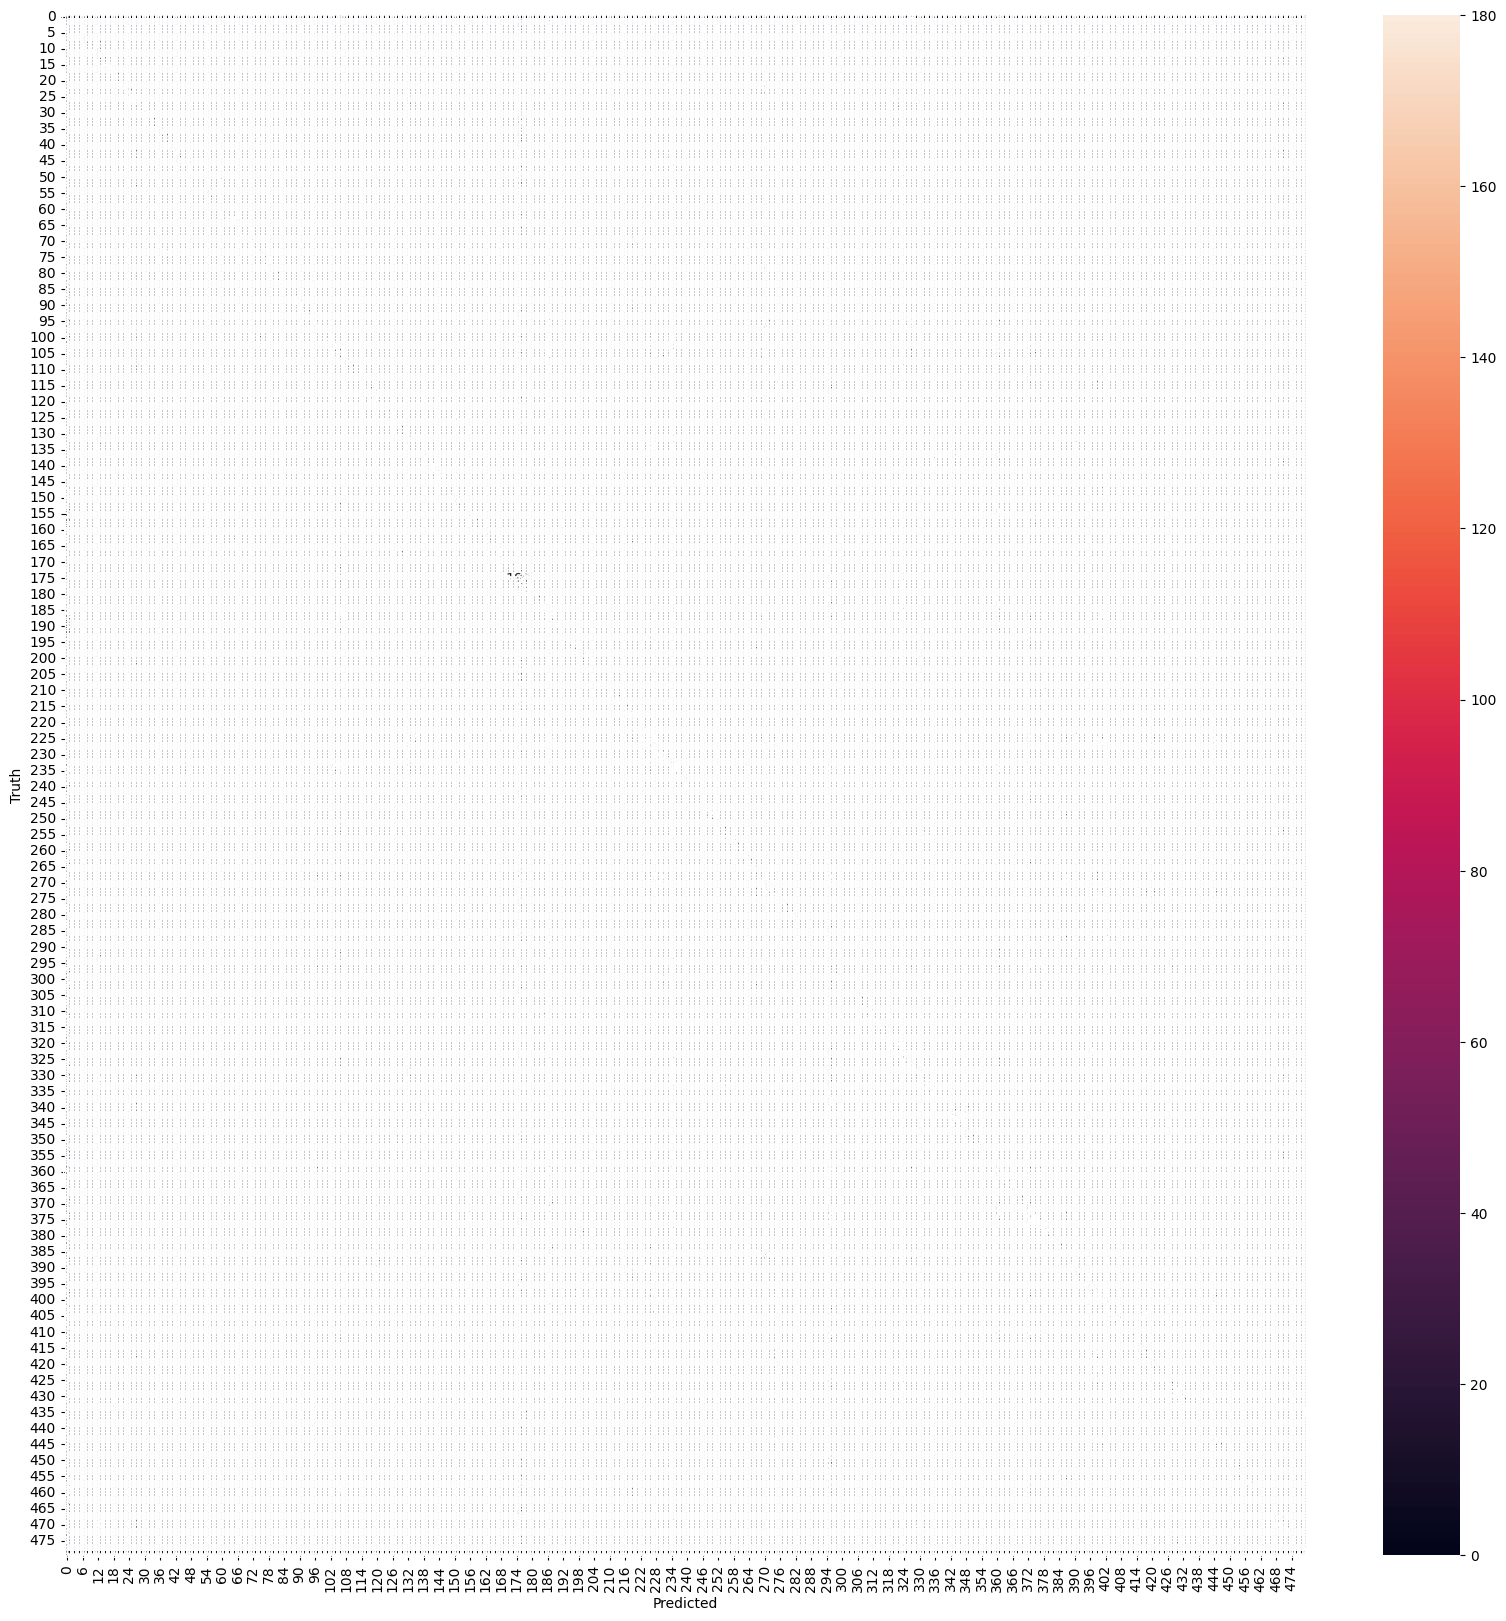

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('20240108_wembedding_traingreat3_test_confusion_matrix.pdf', format='pdf')
plt.show()

In [40]:
data_df_nomed = data_df_orig[data_df_orig['medium'].isna()]
data_df_nomed.shape

(20368, 268)

In [41]:
data_df_nomed_join_embed = data_df_nomed.join(node_embed, how='left')
data_df_nomed_join_embed

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90,91,92,93,94,95,96,97,98,99
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0.326048,-0.403403,1.397577,-0.262198,-0.771518,-0.663971,-0.657180,-2.693955,0.516579,-1.049345
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0.810777,0.563194,1.720983,1.232392,-0.986182,0.605484,0.028389,-1.388129,-2.122279,-1.476511
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,1.863723,1.803987,-0.319616,3.754146,-0.418830,0.998324,2.018780,-3.062002,-1.767797,2.847243
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,-0.181053,1.420939,2.137796,1.840834,-0.281823,-0.186352,0.519962,-2.459532,-0.802931,0.737540
NCBITaxon:1000569,0,0,0,0,0,0,0,0,0,0,...,-0.406371,-1.705035,-0.344652,0.836237,0.068383,1.694684,1.989822,-2.177317,0.046372,-0.093318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999699,1,0,0,1,0,0,0,0,0,0,...,0.270593,0.441660,1.466007,0.100871,-0.253739,-1.881985,-0.676012,-0.925026,-1.742803,0.641783
NCBITaxon:999700,1,0,0,1,0,0,0,0,0,0,...,-0.213614,0.237640,1.385823,0.026044,-0.376723,-2.344338,-0.860686,-0.997028,-2.116375,0.720158
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,1.255571,0.045797,2.323681,1.975510,-0.879350,-1.800230,-0.515825,-0.013546,-0.828897,1.430358


In [42]:
data_df_join_embed2 = data_df_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')
data_df_join_embed2

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90_right,91_right,92_right,93_right,94_right,95_right,96_right,97_right,98_right,99_right
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,3.893311,-1.145257,-3.463747,-0.252844,0.133187,-1.350825,0.083498,3.950952,1.296036,2.421812
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0.162629,-2.273246,-0.231700,-1.809598,0.860964,-1.626807,2.129407,2.420233,-0.656849,1.032531
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,1.029343,0.536299,-1.034751,0.200735,0.113141,-2.872515,2.464246,1.199523,0.352270,-1.801784
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,4.035291,-0.284118,-1.504859,0.025097,1.205971,-0.472054,2.305904,2.952542,1.115550,-0.264006
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0.960424,-0.780511,-0.646330,-1.586410,0.755049,-0.351068,2.620379,2.629001,-0.215337,3.405646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-0.049724,-0.516063,-1.122472,-0.143546,-0.048471,-2.532022,-0.995582,4.884026,0.669134,0.102672
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0.070490,1.371192,-4.092691,-0.763367,-1.182081,-1.621842,1.111404,4.208204,1.606825,0.705671
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,1.084973,-2.020291,-3.073536,-0.745622,0.092240,-2.240415,0.518260,2.996253,-0.029722,0.635136


In [43]:
X2 = data_df_join_embed2.drop('medium', axis=1)
y2 = data_df_join_embed2['medium']


In [44]:
X2.index

Index(['NCBITaxon:100', 'NCBITaxon:1000568', 'NCBITaxon:1001240',
       'NCBITaxon:100133', 'NCBITaxon:1002367', 'NCBITaxon:1002368',
       'NCBITaxon:1002526', 'NCBITaxon:1003', 'NCBITaxon:1003091',
       'NCBITaxon:1003110',
       ...
       'NCBITaxon:999543', 'NCBITaxon:999545', 'NCBITaxon:999547',
       'NCBITaxon:999548', 'NCBITaxon:999549', 'NCBITaxon:999550',
       'NCBITaxon:999552', 'NCBITaxon:999611', 'NCBITaxon:999894',
       'NCBITaxon:999931'],
      dtype='object', name='subject', length=8265)

In [45]:
# Predict on new data
predicted_classes = model.predict(X2)
probabilities = model.predict_proba(X2)
class_probabilities = probabilities[:, 1]
probabilities

array([[1.21995524e-02, 1.25921769e-05, 6.94070981e-06, ...,
        2.82105136e-05, 1.06652039e-05, 3.00791074e-05],
       [2.74378823e-05, 1.08187310e-06, 4.48830085e-06, ...,
        1.77661483e-06, 2.85773976e-06, 3.89619696e-06],
       [7.64218383e-03, 5.55419131e-05, 2.97270825e-05, ...,
        2.56042396e-05, 2.19785095e-05, 7.07099577e-05],
       ...,
       [4.04823262e-04, 2.87489866e-06, 5.38470596e-06, ...,
        1.53216570e-06, 1.98059395e-06, 1.78214335e-06],
       [4.08256894e-03, 8.92694143e-05, 1.22511612e-04, ...,
        9.06839684e-05, 4.27633590e-04, 6.92492022e-05],
       [1.80991806e-03, 1.59647943e-05, 2.87239110e-05, ...,
        5.35435121e-05, 2.47585182e-05, 4.23844267e-05]])

In [46]:
predicted_classes

array([['mediadive.medium:81'],
       ['mediadive.medium:693'],
       ['mediadive.medium:92'],
       ...,
       ['mediadive.medium:514'],
       ['mediadive.medium:514'],
       ['mediadive.medium:830']], dtype=object)

In [47]:
X2.index.values

array(['NCBITaxon:100', 'NCBITaxon:1000568', 'NCBITaxon:1001240', ...,
       'NCBITaxon:999611', 'NCBITaxon:999894', 'NCBITaxon:999931'],
      dtype=object)

In [48]:
max_indices = np.argmax(probabilities, axis=1)

# Find the max values in each row
max_values = np.max(probabilities, axis=1)

# Combine row IDs, max values, and column IDs
result = np.column_stack((np.arange(probabilities.shape[0]), max_values, max_indices))

# Print the result
for row in result:
    print(row)
    print(f"Row ID: {X2.index.values[int(row[0])]}, Max Value: {row[1]}, Max Value Column ID: {predicted_classes[int(row[2])]}")

[  0.           0.94700948 291.        ]
Row ID: NCBITaxon:100, Max Value: 0.947009478295783, Max Value Column ID: ['mediadive.medium:215']
[  1.           0.54829802 259.        ]
Row ID: NCBITaxon:1000568, Max Value: 0.548298018492463, Max Value Column ID: ['mediadive.medium:535']
[  2.           0.92139284 326.        ]
Row ID: NCBITaxon:1001240, Max Value: 0.9213928429575284, Max Value Column ID: ['mediadive.medium:514']
[  3.           0.94542768 308.        ]
Row ID: NCBITaxon:100133, Max Value: 0.9454276837564024, Max Value Column ID: ['mediadive.medium:J746']
[  4.           0.53745448 259.        ]
Row ID: NCBITaxon:1002367, Max Value: 0.5374544814631066, Max Value Column ID: ['mediadive.medium:535']
[  5.           0.94906047 360.        ]
Row ID: NCBITaxon:1002368, Max Value: 0.9490604707510132, Max Value Column ID: ['mediadive.medium:1']
[  6.           0.86754479 396.        ]
Row ID: NCBITaxon:1002526, Max Value: 0.86754478829959, Max Value Column ID: ['mediadive.medium:1

In [49]:

predictions = pd.DataFrame(result, columns=['row_id', 'prob_max', 'media_id'])

predictions['row_id'] = predictions['row_id'].apply(lambda x: X2.index.values[int(x)])
predictions['media_id'] = predictions['media_id'].apply(lambda x: predicted_classes[int(x)][0])

predictions = predictions.sort_values(by='prob_max', ascending=False)

print(predictions)

                 row_id  prob_max              media_id
4561   NCBITaxon:362837  0.999675  mediadive.medium:J12
1890  NCBITaxon:1276229  0.999644  mediadive.medium:J12
2413  NCBITaxon:1458307  0.999606   mediadive.medium:28
841   NCBITaxon:1122249  0.999579  mediadive.medium:J12
4830   NCBITaxon:391616  0.999571   mediadive.medium:28
...                 ...       ...                   ...
542   NCBITaxon:1121257  0.051571  mediadive.medium:144
1860  NCBITaxon:1266720  0.049136  mediadive.medium:830
335   NCBITaxon:1095805  0.037489   mediadive.medium:81
7378    NCBITaxon:73030  0.035384  mediadive.medium:514
7697   NCBITaxon:859243  0.033154  mediadive.medium:J13

[8265 rows x 3 columns]


In [50]:
predictions[predictions['prob_max'] > 0.99]

,row_id,prob_max,media_id
4561,NCBITaxon:362837,0.999675,mediadive.medium:J12
1890,NCBITaxon:1276229,0.999644,mediadive.medium:J12
2413,NCBITaxon:1458307,0.999606,mediadive.medium:28
841,NCBITaxon:1122249,0.999579,mediadive.medium:J12
4830,NCBITaxon:391616,0.999571,mediadive.medium:28
...,...,...,...
772,NCBITaxon:1122155,0.990082,mediadive.medium:11
5187,NCBITaxon:425504,0.990065,mediadive.medium:462
2296,NCBITaxon:1416776,0.990051,mediadive.medium:514
1047,NCBITaxon:1123324,0.990048,mediadive.medium:693


In [51]:
type(result)

numpy.ndarray

In [52]:
Spiroplasma cantharicola - mosquito associated
Spiroplasma syrphidicola EA-1 - syphid fly
Mycoplasmopsis sturni DSM 22021 - Conjunctiva of European starling Sturnus vulgaris
12 . NUTRIENT BROTH WITH 0.5% NaCl


Octadecabacter temperatus
28 . PFENNIG'S MEDIUM I 


SyntaxError: invalid syntax (3476213952.py, line 1)

In [55]:
data_df_nomed = data_df_orig[data_df_orig['medium'].isna()]
data_df_nomed.shape

data_df_nomed_join_embed = data_df_nomed.join(node_embed, how='left')
data_df_nomed_join_embed

data_df_join_embed2 = data_df_nomed_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')
data_df_join_embed2

X2 = data_df_join_embed2.drop('medium', axis=1)
y2 = data_df_join_embed2['medium']

# Predict on new data
predicted_classes = model.predict(X2)
probabilities = model.predict_proba(X2)  # Probabilities for the positive class

max_indices = np.argmax(probabilities, axis=1)

# Find the max values in each row
max_values = np.max(probabilities, axis=1)

# Combine row IDs, max values, and column IDs
result = np.column_stack((np.arange(probabilities.shape[0]), max_values, max_indices))

#for row in result:
#    print(row)
#    print(f"Row ID: {X2.index.values[int(row[0])]}, Max Value: {row[1]}, Max Value Column ID: {predicted_classes[int(row[2])]}")

predictions = pd.DataFrame(result, columns=['row_id', 'prob_max', 'media_id'])

predictions['row_id'] = predictions['row_id'].apply(lambda x: X2.index.values[int(x)])
predictions['media_id'] = predictions['media_id'].apply(lambda x: predicted_classes[int(x)][0])

predictions = predictions.sort_values(by='prob_max', ascending=False)

predictions = predictions.merge(data_nodes[['id', 'name']], left_on='row_id', right_on='id', how='left')
predictions.rename(columns={'name': 'row_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

# Merge to get media_id_label
predictions = predictions.merge(data_nodes[['id', 'name']], left_on='media_id', right_on='id', how='left')
predictions.rename(columns={'name': 'media_id_label'}, inplace=True)
predictions.drop('id', axis=1, inplace=True)  # Remove the extra 'id' column

def extract_ncbi_id(row_id):
    return row_id.split(':')[-1]

# Function to extract ID after colon for MediaDive link
def extract_media_id(media_id):
    return media_id.split(':')[-1]

# Create the ncbi_link column
predictions['ncbi_link'] = 'https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=' + predictions['row_id'].apply(extract_ncbi_id)

# Create the media_link column
predictions['media_link'] = 'https://mediadive.dsmz.de/medium/' + predictions['media_id'].apply(extract_media_id)

new_column_order = ['row_id', 'media_id', 'prob_max', 'row_id_label', 'media_id_label', 'ncbi_link', 'media_link']

predictions = predictions[new_column_order]

In [56]:
predictions[predictions['prob_max'] > 0.99]

,row_id,media_id,prob_max,row_id_label,media_id_label,ncbi_link,media_link
0,NCBITaxon:487319,mediadive.medium:830,0.999386,Shewanella marina,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
1,NCBITaxon:1583767,mediadive.medium:830,0.998773,Vibrio sp. PID23_8,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
2,NCBITaxon:418853,mediadive.medium:830,0.998167,Sneathiella glossodoripedis,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
3,NCBITaxon:483012,mediadive.medium:693,0.997792,Liquorilactobacillus cacaonum,COLUMBIA BLOOD MEDIUM (DSMZ Medium 693),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/693
4,NCBITaxon:490979,mediadive.medium:830,0.997722,Rubellimicrobium aerolatum,R2A MEDIUM (DSMZ Medium 830),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/830
...,...,...,...,...,...,...,...
63,NCBITaxon:390884,mediadive.medium:693,0.991054,Echinicola vietnamensis,COLUMBIA BLOOD MEDIUM (DSMZ Medium 693),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/693
64,NCBITaxon:75658,mediadive.medium:693,0.990923,Campylobacter lanienae,COLUMBIA BLOOD MEDIUM (DSMZ Medium 693),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/693
65,NCBITaxon:796620,mediadive.medium:693,0.990712,Vibrio caribbeanicus ATCC BAA-2122,COLUMBIA BLOOD MEDIUM (DSMZ Medium 693),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/693
66,NCBITaxon:925776,mediadive.medium:220,0.990582,Xanthomonas perforans 91-118,CASO AGAR (MERCK 105458) (DSMZ Medium 220),https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/...,https://mediadive.dsmz.de/medium/220


In [57]:
predictions.to_csv('pred20240110_wembeddings_traingreat1.tsv', sep='\t', index=False)